# Data Preparation

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import json

# Path to the dataset
#train_file_path = "/content/drive/MyDrive/winter2025/cse156 natural language processing/final project/strategyqa/data/strategyqa/train.json"
train_file_path = "train.json"

def flatten_evidence(evidence):
    flattened = []
    for item in evidence:
        try:
          while isinstance(item[0], list):
            item = item[0]
          for evidence_item in item:
            flattened.append(evidence_item)
        except: continue
    return flattened

# Load and parse the dataset
def load_strategyqa_train_data(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)  # Load JSON file

    train_data = []

    for item in data:
        parsed_entry = {
            "id": item.get("qid", ""),
            "term": item.get("term", ""),  # Extract term
            "description": item.get("description", ""),  # Extract description
            "question": item["question"],  # Extract question
            "answer": item["answer"],  # Extract answer (True/False)
            "facts": item.get("facts", []),  # Extract facts
            "decomposition": item.get("decomposition", []),  # Extract decomposition
            "evidence": flatten_evidence(item.get("evidence", []))  # Extract evidence
        }
        train_data.append(parsed_entry)

    return train_data

# Load the training data
train_data = load_strategyqa_train_data(train_file_path)

# Print a sample entry
print(json.dumps(train_data[:2], indent=4))  # Display first two entries for verification
print(len(train_data))

[
    {
        "id": "2bc9c4f9c19c167187f2",
        "term": "Genghis Khan",
        "description": "founder and first Great Khan of the Mongol Empire",
        "question": "Are more people today related to Genghis Khan than Julius Caesar?",
        "answer": true,
        "facts": [
            "Julius Caesar had three children.",
            "Genghis Khan had sixteen children.",
            "Modern geneticists have determined that  out of every 200 men today has DNA that can be traced to Genghis Khan."
        ],
        "decomposition": [
            "How many kids did Julius Caesar have?",
            "How many kids did Genghis Khan have?",
            "Is #2 greater than #1?"
        ],
        "evidence": [
            "Caesarion-2",
            "Julia (daughter of Caesar)-1",
            "Julius Caesar-75",
            "Gaius Julius Caesar-7"
        ]
    },
    {
        "id": "03caf265939fab701dee",
        "term": "The Police",
        "description": "English rock band",
  

In [3]:
# from transformers import RobertaTokenizer
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch
import torch.nn as nn
# tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

class QuestionDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

        # Add a special token to separate decomposition and evidence
        self.sep_token = "[SEP]"
        if self.sep_token not in self.tokenizer.get_vocab():
            self.tokenizer.add_tokens([self.sep_token])
            # Resize the model's token embeddings if necessary
            # # if hasattr(self, "gpt2"):
            #     self.gpt2.resize_token_embeddings(len(self.tokenizer))
            self.tokenizer.model_max_length = self.max_len  # if you need this
            self.tokenizer.init_kwargs['model_max_length'] = self.max_len  # if you need this

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        item = self.data[index]
        id = item['id']
        question = item["question"]
        term = item["term"]
        description = item["description"]
        facts = " ".join(item["facts"])
        decomposition = item["decomposition"]
        evidence = item["evidence"]

        # Combine inputs (question, term, description, facts)
        combined_input = f"{question} {term} {description} {facts}"

        # Tokenize the input
        encoding = self.tokenizer(
            combined_input,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        # 1. Binary Answer Label
        answer_label = 1 if item["answer"] else 0
        answer_label = torch.tensor(answer_label, dtype=torch.float)

        # 2. Tokenize decomposition and evidence
        # label = f"{decomposition} {self.sep_token} {evidence}"
        label = ""
        for i in decomposition:
          label += i + " "
        label += self.sep_token
        for i in evidence:
          label += "|" + i

        combined_labels = self.tokenizer(
            label,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
            is_split_into_words=True
        )["input_ids"].squeeze(0)

        finetune_label = combined_input + self.sep_token + label
        finetune_encoding = self.tokenizer(
            finetune_label,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
# Check for invalid label values
        vocab_size = len(self.tokenizer)
        if (combined_labels >= vocab_size).any():
            raise ValueError(f"Invalid label value found. Label values must be less than {vocab_size}.")

        return {
            "id": id,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "answer_label": answer_label,
            "labels": combined_labels,  # Combined decomposition and evidence with a special token
            "finetune_input_ids": finetune_encoding["input_ids"].squeeze(0),
            "finetune_attention_mask": finetune_encoding["attention_mask"].squeeze(0)
        }

# Load dataset
train_dataset = QuestionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load dataset
train_dataset = QuestionDataset(train_data, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

2025-03-19 23:34:18.960273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-19 23:34:18.960343: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-19 23:34:18.961585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-19 23:34:18.970190: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(tokenizer.decode(next(iter(train_loader))["labels"][0],skip_special_tokens=True))
# next(iter(train_loader))["labels"][0].shape
print(next(iter(train_loader))["finetune_input_ids"], next(iter(train_loader))["finetune_attention_mask"])

What was the nature of Pan's relation with women? Is #1 not sexual?  [SEP] |Pan (god)-17|Pan (god)-17|Pan (god)-18|Pan (god)-17|Pan (god)-18
tensor([[17353,   281,  3056,  ..., 50256, 50256, 50256],
        [ 3792,  6786, 13943,  ..., 50256, 50256, 50256],
        [13921,   262,  2297,  ..., 50256, 50256, 50256],
        ...,
        [16973,   262,   412,  ..., 50256, 50256, 50256],
        [23722,  4231, 12898,  ..., 50256, 50256, 50256],
        [11633,   262, 26633,  ..., 50256, 50256, 50256]]) tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])


In [5]:
#val_data = "/content/drive/MyDrive/winter2025/cse156 natural language processing/final project/strategyqa/data/strategyqa/dev.json"
val_data = 'dev.json'
val_data = load_strategyqa_train_data(val_data)
val_dataset = QuestionDataset(val_data, tokenizer)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
print(len(val_dataset))

229


# Model architecture

In [6]:
# import torch
# import torch.nn as nn
# from transformers import GPT2Model, GPT2Tokenizer, GPT2LMHeadModel

# class GPT2MultiTaskWrapper(nn.Module):
#     def __init__(self, gpt2_model_name='gpt2', max_len=512):
#         super(GPT2MultiTaskWrapper, self).__init__()
#         self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model_name)
#         self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
#         self.tokenizer.padding_side = 'left'
#         self.max_len = max_len

#         # Add a special token to separate decomposition and evidence
#         self.sep_token = "[SEP]"
#         if self.sep_token not in self.tokenizer.get_vocab():
#             self.tokenizer.add_tokens([self.sep_token])
#             self.gpt2.resize_token_embeddings(len(self.tokenizer))  # Resize embeddings

#         # Set padding token if not already set
#         # if self.tokenizer.pad_token is None:
#         self.tokenizer.pad_token = self.tokenizer.eos_token

#         # Additional layers for the classification task
#         self.fc1 = nn.Linear(self.gpt2.config.vocab_size, self.max_len)
#         self.fc2 = nn.Linear(self.max_len, 128)
#         self.fc3 = nn.Linear(128, 1)
#         self.relu = nn.ReLU()
#         self.sigmoid = nn.Sigmoid()

#     def forward_generate(self, input_ids, labels, attention_mask):
#         # Generate text for decomposition and evidence
#         outputs = self.gpt2(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
#         return outputs

#     def forward_classify(self, input_ids, attention_mask):
#         # First, generate text from input_ids and attention_mask, make sure the generate_outputs has shape [batch_size, self.max_len]
#         generate_outputs = self.gpt2.generate(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             max_new_tokens=self.max_len, do_sample=True, top_p=0.95, top_k=50,
#             num_return_sequences=1,
#             )
#         # encode the generate outputs and feed it to gpt2 to get logits
#         generated_text = self.tokenizer.batch_decode(generate_outputs, skip_special_tokens=True)
#         encoded = self.tokenizer(generated_text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt").to(device)

#         # Get logits of generated outputs
#         generated_logit = self.gpt2(input_ids=encoded["input_ids"], attention_mask=encoded["attention_mask"]).logits

#         # Pass through the fully connected layers for classification
#         fc1_output = self.relu(self.fc1(generated_logit))  # Shape: [batch_size, sequence_length, max_len]
#         fc2_output = self.relu(self.fc2(fc1_output))        # Shape: [batch_size, sequence_length, 128]
#         fc3_output = self.sigmoid(self.fc3(fc2_output))     # Shape: [batch_size, sequence_length, 1]
#         fc3_output = fc3_output.squeeze(dim=-1)  # Remove the last dimension (size 1)

#         # Aggregate over the sequence dimension (e.g., take the mean) or sum
#         final_output = fc3_output.sum(dim=1)           # Shape: [batch_size, 1]

#         return generated_text, final_output # Removed the extra return statement

#     def generate(self, input_ids, attention_mask,  max_new_tokens=128, skip_spec_tokens=True,padding_side='left'):
#         # Generate text using GPT-2
#         generated_ids = self.gpt2.generate(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             max_new_tokens=max_new_tokens,
#             # num_return_sequences=1
#         )
#         res = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=skip_spec_tokens, padding_side=padding_side)
#         # for gen in generated_ids:
#         #     res.append(self.tokenizer.decode(gen, skip_special_tokens=skip_spec_tokens))
#         # return self.tokenizer.decode(generated_ids, skip_special_tokens=True, padding_side=padding_side)
#         return res
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel

class GPT2MultiTaskWrapper(nn.Module):
    def __init__(self, gpt2_model_name='gpt2', max_len=512):
        super(GPT2MultiTaskWrapper, self).__init__()
        self.gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model_name)
        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
        self.tokenizer.padding_side = 'left'
        self.max_len = max_len

        # Add a special token to separate decomposition and evidence
        self.sep_token = "[SEP]"
        if self.sep_token not in self.tokenizer.get_vocab():
            self.tokenizer.add_tokens([self.sep_token])
            self.gpt2.resize_token_embeddings(len(self.tokenizer))

        # Set padding token
        self.tokenizer.pad_token = self.tokenizer.eos_token

        # Fully connected layers for classification
        self.fc1 = nn.Linear(self.gpt2.config.hidden_size, 128)  # Use hidden_size, not vocab_size
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward_generate(self, input_ids, labels, attention_mask):
        outputs = self.gpt2(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
        return outputs

    def forward_classify(self, input_ids, attention_mask):
        # Generate text from the model
        generate_outputs = self.gpt2.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=self.max_len,
            do_sample=True,
            top_p=0.95,
            top_k=50,
            num_return_sequences=1
        )

        # Decode and tokenize generated text
        generated_text = self.tokenizer.batch_decode(generate_outputs, skip_special_tokens=True)
        encoded = self.tokenizer(generated_text, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt").to(input_ids.device)

        # Get hidden states from GPT-2 instead of logits
        outputs = self.gpt2(input_ids=encoded["input_ids"], attention_mask=encoded["attention_mask"], output_hidden_states=True)
        hidden_states = outputs.hidden_states[-1]  # Get last layer hidden states (shape: [batch, seq_len, hidden_size])

        # Apply mean pooling across sequence dimension
        pooled_output = hidden_states.mean(dim=1)  # Shape: [batch_size, hidden_size]

        # Fully connected layers
        fc1_output = self.relu(self.fc1(pooled_output))  # Shape: [batch_size, 128]
        fc2_output = self.relu(self.fc2(fc1_output))      # Shape: [batch_size, 64]
        fc3_output = self.sigmoid(self.fc3(fc2_output))   # Shape: [batch_size, 1]

        return generated_text, fc3_output.squeeze()  # Return final classification score

    def generate(self, input_ids, attention_mask, max_new_tokens=128, skip_spec_tokens=True):
        generated_ids = self.gpt2.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
        )
        return self.tokenizer.batch_decode(generated_ids, skip_special_tokens=skip_spec_tokens)


In [7]:
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn

def train_generation(model, dataloader, optimizer, device, epochs=3):
    """
    Train the model on the generation task (decomposition and evidence combined).
    Returns:
        train_losses (list): List of training losses per epoch.
    """
    for param in model.gpt2.parameters():
        param.requires_grad = True

    # Ensure the fully connected layers are trainable
    for param in model.fc1.parameters():
        param.requires_grad = False
    for param in model.fc2.parameters():
        param.requires_grad = False
    for param in model.fc3.parameters():
        param.requires_grad = False

    model.train()
    train_losses = []

    # loss_fn = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding tokens if necessary

    for epoch in range(epochs):
        epoch_loss = 0.0
        for batch in dataloader:
            input_ids = batch["finetune_input_ids"].to(device)
            attention_mask = batch["finetune_attention_mask"].to(device)
            labels = batch["finetune_input_ids"].to(device)  # Should shift this

            optimizer.zero_grad()

            # Forward pass
            outputs = model.gpt2(input_ids=input_ids, labels=labels, attention_mask=attention_mask, token_type_ids=None)
            loss = outputs[0]

            # Backpropagation
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Compute average loss for the epoch
        avg_epoch_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}")

    return train_losses


def train_classification(model, train_dataloader, val_dataloader, optimizer, device, epochs=3):
    """
    Train the model on the classification task (True/False answer).
    Returns:
        train_losses (list): List of training losses per epoch.
        train_accs (list): List of training accuracies per epoch.
        val_accs (list): List of validation accuracies per epoch.
    """
        # Freeze the GPT-2 model parameters
    for param in model.gpt2.parameters():
        param.requires_grad = False

    # Ensure the fully connected layers are trainable
    for param in model.fc1.parameters():
        param.requires_grad = True
    for param in model.fc2.parameters():
        param.requires_grad = True
    for param in model.fc3.parameters():
        param.requires_grad = True
    model.train()
    train_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        all_preds = []
        all_labels = []

        # Training loop
        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            answer_labels = batch["answer_label"].to(device)

            optimizer.zero_grad()

            # Forward pass for classification
            _, classify_outputs = model.forward_classify(input_ids, attention_mask)

            # Calculate loss for classification
            loss = nn.BCELoss()(classify_outputs, answer_labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Collect predictions and labels for accuracy calculation
            preds = (classify_outputs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(answer_labels.cpu().numpy())

        # Calculate training accuracy
        train_acc = accuracy_score(all_labels, all_preds)
        train_accs.append(train_acc)

        # Calculate average training loss
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        train_losses.append(avg_epoch_loss)

        # Evaluate on validation set
        val_acc = evaluate(model, val_dataloader, device)
        val_accs.append(val_acc)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss}, Train Acc: {train_acc}, Val Acc: {val_acc}")

    return train_losses, train_accs, val_accs

def evaluate(model, dataloader, device):
    """
    Evaluate the model on the validation dataset.
    Returns:
        accuracy (float): Accuracy on the validation set.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            answer_labels = batch["answer_label"].to(device)

            # Forward pass for classification
            _, classify_outputs = model.forward_classify(input_ids, attention_mask)

            # Collect predictions and labels
            preds = (classify_outputs.squeeze() > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(answer_labels.cpu().numpy())

    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    return accuracy

## model init

In [8]:
# Declare model, optimizer, and hyperparameters
from torch.optim import AdamW
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = GPT2MultiTaskWrapper(gpt2_model_name='gpt2')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)


cuda


The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


# sneakpeek the model

In [9]:
# a = next(iter(train_loader))
# model.eval()
# input_ids = a["input_ids"].to(device)
# attention_mask = a["attention_mask"].to(device)
# answer_labels = a["answer_label"].to(device)
# finetune_ids = a["finetune_input_ids"].to(device)
# finetune_attention_mask = a["finetune_attention_mask"].to(device)
# print(input_ids.shape)
# print(attention_mask.shape)
# print(answer_labels.shape)
# print(finetune_ids.shape)
# print(finetune_attention_mask.shape)

## check train classify

In [10]:
# generate_outputs = model.gpt2.generate(
#             input_ids=input_ids,
#             attention_mask=attention_mask,
#             max_new_tokens=model.max_len, do_sample=True, top_p=0.95, top_k=50,
#             num_return_sequences=1,
#             )
# # encode the generate outputs and feed it to gpt2 to get logits
# generated_text = model.tokenizer.batch_decode(generate_outputs, skip_special_tokens=True)
# print("generated text: ", generated_text)

# encoded = model.tokenizer(generated_text, padding="max_length", truncation=True, max_length=model.max_len, return_tensors="pt").to(device)
# # Get logits of generated outputs
# generated_logit = model.gpt2(input_ids=encoded["input_ids"], attention_mask=encoded["attention_mask"]).logits
# print(generated_logit.shape)

# # Pass through the fully connected layers for classification
# fc1_output = model.relu(model.fc1(generated_logit))  # Shape: [batch_size, sequence_length, max_len]
# print("fc1: ", fc1_output.shape)
# fc2_output = model.relu(model.fc2(fc1_output))        # Shape: [batch_size, sequence_length, 128]
# print("fc2: ", fc2_output.shape)
# fc3_output = model.sigmoid(model.fc3(fc2_output))     # Shape: [batch_size, sequence_length, 1]
# print("fc3: ", fc3_output.shape)
# fc3_output = fc3_output.squeeze(dim=-1)  # Remove the last dimension (size 1)
# print("fc3: ", fc3_output.shape)

# # Aggregate over the sequence dimension (e.g., take the mean) or sum
# final_output = fc3_output.sum(dim=1)           # Shape: [batch_size, 1]

In [11]:
# generate, outputs = model.forward_classify(input_ids, attention_mask)
# print(generate)
# print(outputs)

# Train

In [12]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()


In [13]:
# Train generation task
train_losses_generation = train_generation(model, train_loader, optimizer, device, epochs=15)

#second time
# Epoch 1/5, Loss: 0.5354869082685589
# Epoch 2/5, Loss: 0.5263115733630898
# Epoch 3/5, Loss: 0.5189257326514222
# Epoch 4/5, Loss: 0.5084669057481973
# Epoch 5/5, Loss: 0.49896417269411014

# third time
# Epoch 1/5, Loss: 0.48912694391816164
# Epoch 2/5, Loss: 0.4797149912793507
# Epoch 3/5, Loss: 0.4705398406169211
# Epoch 4/5, Loss: 0.4600732234097266
# Epoch 5/5, Loss: 0.4514299573362336

Epoch 1/15, Loss: 0.6963331749041876
Epoch 2/15, Loss: 0.49967538155326546
Epoch 3/15, Loss: 0.45926074752973955
Epoch 4/15, Loss: 0.4271809121435003
Epoch 5/15, Loss: 0.39894846901875136
Epoch 6/15, Loss: 0.37268715888954873
Epoch 7/15, Loss: 0.346511992142182
Epoch 8/15, Loss: 0.32200465114541754
Epoch 9/15, Loss: 0.2983169981329016
Epoch 10/15, Loss: 0.2753411380126495
Epoch 11/15, Loss: 0.25318503789892494
Epoch 12/15, Loss: 0.23241458278755808
Epoch 13/15, Loss: 0.2127369465522988
Epoch 14/15, Loss: 0.19458764294783273
Epoch 15/15, Loss: 0.17695534815506417


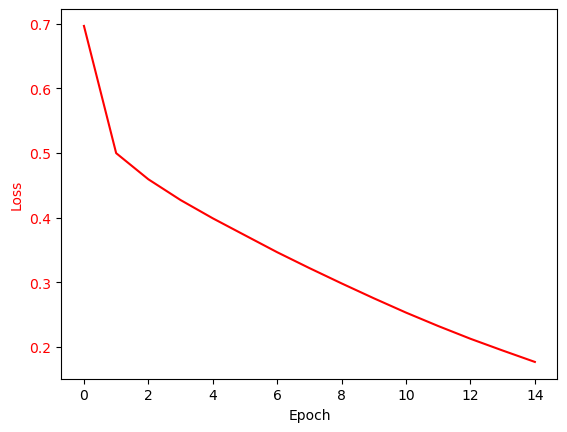

In [14]:
import matplotlib.pyplot as plt
def plot_gen(losses):
  fig, ax1 = plt.subplots()

  # Plot Losses
  color = 'red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(losses, color=color, label='Training Loss')  # Add label for legend
  ax1.tick_params(axis='y', labelcolor=color)
  plt.show()
plot_gen(train_losses_generation)

In [15]:
# Train classification task
train_losses, train_accs, val_accs = train_classification(model, train_loader, val_loader, optimizer, device, epochs=15)

# second time gpt weight freezed
# Epoch 1/5, Loss: 0.7808138812466185, Train Acc: 0.5511887433284813, Val Acc: 0.5502183406113537
# Epoch 2/5, Loss: 0.9108427918350049, Train Acc: 0.5487627365356623, Val Acc: 0.5283842794759825
# Epoch 3/5, Loss: 0.8139247562765151, Train Acc: 0.5730228044638525, Val Acc: 0.5676855895196506
# Epoch 4/5, Loss: 0.7405972984410072, Train Acc: 0.5909752547307132, Val Acc: 0.5676855895196506
# Epoch 5/5, Loss: 0.7704617967901304, Train Acc: 0.5788452207666182, Val Acc: 0.5545851528384279
# third time
# Epoch 1/5, Loss: 0.6884992286678433, Train Acc: 0.5851528384279476, Val Acc: 0.5807860262008734
# Epoch 2/5, Loss: 0.7465883102989936, Train Acc: 0.5934012615235322, Val Acc: 0.5545851528384279
# Epoch 3/5, Loss: 0.747816759602044, Train Acc: 0.5851528384279476, Val Acc: 0.5633187772925764
# Epoch 4/5, Loss: 0.7356629175271174, Train Acc: 0.5880640465793304, Val Acc: 0.5720524017467249
# Epoch 5/5, Loss: 0.7316327135461246, Train Acc: 0.5977680737506065, Val Acc: 0.5502183406113537

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 1/15, Loss: 0.6949774793876234, Train Acc: 0.519650655021834, Val Acc: 0.5283842794759825


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 2/15, Loss: 0.6896605981412784, Train Acc: 0.5254730713245997, Val Acc: 0.5851528384279476


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 3/15, Loss: 0.6896598583968111, Train Acc: 0.5361475012130034, Val Acc: 0.537117903930131


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 4/15, Loss: 0.6884408812652263, Train Acc: 0.5390587093643863, Val Acc: 0.537117903930131


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 5/15, Loss: 0.6877222430798434, Train Acc: 0.5511887433284813, Val Acc: 0.5414847161572053


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 6/15, Loss: 0.6855881378170132, Train Acc: 0.5429403202328966, Val Acc: 0.519650655021834


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 7/15, Loss: 0.6855198137981947, Train Acc: 0.5443959243085881, Val Acc: 0.5458515283842795


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 8/15, Loss: 0.686489576055098, Train Acc: 0.5361475012130034, Val Acc: 0.5633187772925764


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 9/15, Loss: 0.6848726979521818, Train Acc: 0.5463367297428433, Val Acc: 0.5502183406113537


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 10/15, Loss: 0.6837030859418618, Train Acc: 0.5492479378942261, Val Acc: 0.5502183406113537


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 11/15, Loss: 0.6834791889486387, Train Acc: 0.5458515283842795, Val Acc: 0.5414847161572053


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 12/15, Loss: 0.6816467621991801, Train Acc: 0.5608927704997574, Val Acc: 0.6200873362445415


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 13/15, Loss: 0.6795074297476185, Train Acc: 0.5633187772925764, Val Acc: 0.5938864628820961


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 14/15, Loss: 0.6806005096250727, Train Acc: 0.5550703541969918, Val Acc: 0.5458515283842795


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Setting `pad_token_id` t

Epoch 15/15, Loss: 0.6810897387737451, Train Acc: 0.5608927704997574, Val Acc: 0.5851528384279476


# Result

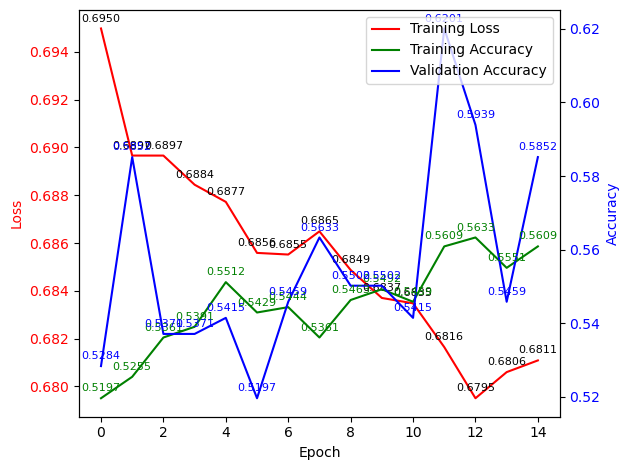

In [16]:

def plot_results(losses, train_accs, val_accs):
  # losses = [loss.cpu().item() for loss in losses]
  fig, ax1 = plt.subplots()

  # Plot Losses
  color = 'red'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss', color=color)
  ax1.plot(losses, color=color, label='Training Loss')  # Add label for legend
  ax1.tick_params(axis='y', labelcolor=color)

  # Add loss values to the plot
  for i, loss in enumerate(losses):
      ax1.annotate(f'{loss:.4f}', (i, loss), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

  # Plot Accuracies
  ax2 = ax1.twinx()
  color = 'blue'
  ax2.set_ylabel('Accuracy', color=color)
  ax2.plot(train_accs, color='green', label='Training Accuracy')  # Add label for legend
  ax2.plot(val_accs, color='blue', label='Validation Accuracy')  # Add label for legend
  ax2.tick_params(axis='y', labelcolor=color)

  # Add accuracy values to the plot
  for i, train_acc, val_acc in zip(range(len(train_accs)), train_accs, val_accs):
      ax2.annotate(f'{train_acc:.4f}', (i, train_acc), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='green')
      ax2.annotate(f'{val_acc:.4f}', (i, val_acc), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8, color='blue')

  fig.tight_layout()
  fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes) # place legend outside of the plot.
  plt.show()

plot_results(train_losses, train_accs, val_accs)

In [17]:
# save model
torch.save(model.state_dict(), 'model.pth')

# Eval

In [18]:
def compile_output(model, dataloader,device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Compiles the outputs of the answer classifier and decomposition/evidence generator into a JSON file.

    Args:
        model: Trained GPT2MultiTaskWrapper model.
        dataloader: DataLoader containing the evaluation data.
        tokenizer: GPT2Tokenizer used for the model.
        device: Device to run the model on (CPU or CUDA).

    Returns:
        A dictionary containing the compiled predictions.
    """
    model.eval()

    predictions = {}

    with torch.no_grad():
        count = 0
        for batch in dataloader:
            print("count: ", count)
            count+=1
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            item_ids = batch['id']
            # Answer Classification
            _, answer_logits = model.forward_classify(input_ids, attention_mask)
            answer_preds = (answer_logits.squeeze() > 0.5).float()
            answer_preds_bool = answer_preds.cpu().tolist()  # Convert to boolean

            generated_text = model.generate(input_ids, attention_mask,50)
            for i, item_id in enumerate(item_ids):
              # Decomposition/Evidence generation
              # label_text = model.generate(input_ids, attention_mask,50)
              label_text = generated_text[i]
              if model.sep_token not in label_text:
                  print('SEP not in generated text')
                  print(label_text)
                  continue
              decomposition_text, paragraph_text = label_text.split(tokenizer.sep_token)
              decomposition_text = decomposition_text.strip()
              # trip paragraph_text from end token and space
              paragraph_text = paragraph_text.replace(tokenizer.eos_token, "")
              paragraph_text = paragraph_text.strip().rstrip()

              # process text into list
              decomposition_list = [q.strip() for q in decomposition_text.split("?") if q.strip()]
              decomposition_list = [q + "?" for q in decomposition_list]  # Add '?' back to each question
              # Process paragraphs (evidence)
              paragraph_list = [p.strip() for p in paragraph_text.split("|") if p.strip()]

              predictions[item_id] = {
                  # "answer": answer_preds_bool[i],
                  "decomposition": decomposition_list,
                  "paragraphs": paragraph_list
              }
    return predictions

In [19]:
# d = val_data[:3]
# dd = QuestionDataset(d, tokenizer)
# dloader = DataLoader(dd, batch_size=8, shuffle=False)
# # a = compile_output(model, dloader, tokenizer)
# for batch in dloader:
#   input_ids = batch["input_ids"].to(device)
#   attention_mask = batch["attention_mask"].to(device)
#   item_ids = batch['id']
#   generated_text = model.generate(input_ids, attention_mask)
#   # print(generated_text)
#   for i, item_id in enumerate(item_ids):
#       # Decomposition/Evidence generation
#       label_text = generated_text[i]
#       print(label_text)
#       decomposition_text, paragraph_text = label_text.split(tokenizer.sep_token)
#       decomposition_text = decomposition_text.strip()
#       # trip paragraph_text from end token and space
#       paragraph_text = paragraph_text.replace(tokenizer.eos_token, "")
#       paragraph_text = paragraph_text.strip().rstrip()

#       # process text into list
#       decomposition_list = [q.strip() for q in decomposition_text.split("?") if q.strip()]
#       decomposition_list = [q + "?" for q in decomposition_list]  # Add '?' back to each question
#       # Process paragraphs (evidence)
#       paragraph_list = [p.strip() for p in paragraph_text.split("|") if p.strip()]
#       print(decomposition_list)
#       print(paragraph_list)